In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from ultralytics.utils.ops import scale_image  # Contains letterbox functionality

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU
torch.set_num_threads(4)  # Adjust based on your CPU cores

In [3]:
model = YOLO("yolo-models\yolo11x-obb.pt").to('cpu')

<>:1: SyntaxWarning: invalid escape sequence '\y'
<>:1: SyntaxWarning: invalid escape sequence '\y'
C:\Users\cuong\AppData\Local\Temp\ipykernel_53992\2838375714.py:1: SyntaxWarning: invalid escape sequence '\y'
  model = YOLO("yolo-models\yolo11x-obb.pt").to('cpu')


In [4]:
image_path = 'images\\bo du lieu bia so 4\\bia4 (12).bmp'
image = cv2.imread(image_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [5]:
# Hàm kiểm tra xem điểm có nằm trong hộp giới hạn xoay không
def point_in_rotated_box(point, box):
    return cv2.pointPolygonTest(box, point, False) >= 0

# Hàm tải và xử lý ảnh
def preprocess_image(image_path, img_size=640, device='cpu'):  # Changed to cpu
    img0 = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    
    # Resize
    h, w = img0.shape[:2]
    scale = min(img_size/h, img_size/w)
    new_h, new_w = int(h * scale), int(w * scale)
    img = cv2.resize(img0, (new_w, new_h))
    
    # Convert to tensor
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).float()  # Removed .to(device)
    img /= 255.0
    
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
        
    return img, img0, img_rgb

# Detection function - returns raw detection results
def detect_objects(image_path, model):
    # Load and preprocess image
    img, img0, img_rgb = preprocess_image(image_path)
    
    # Perform detection
    results = model.predict(img_rgb)
    
    # Prepare detection data
    detections = []
    for result in results:
        if result.boxes is not None and len(result.boxes) > 0:
            # Get rotated boxes and metadata
            boxes = result.boxes.xywhr.cpu().numpy()  # x,y,w,h,rotation
            confs = result.boxes.conf.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy()
            
            for box, conf, cls in zip(boxes, confs, classes):
                detections.append({
                    'box': box,  # [cx, cy, w, h, angle]
                    'confidence': conf,
                    'class_id': cls,
                    'class_name': model.names[int(cls)]
                })
    
    return img_rgb, detections

# Visualization function - takes detection results and displays them
def visualize_detections(img_rgb, detections, output_path=None):
    # Create a copy of the image to draw on
    vis_img = img_rgb.copy()
    
    for detection in detections:
        box = detection['box']
        # Convert rotated box to polygon
        cx, cy, w, h, angle = box
        rect = ((cx, cy), (w, h), angle)
        box_points = cv2.boxPoints(rect)
        box_points = np.int0(box_points)
        
        # Draw rotated rectangle
        cv2.drawContours(vis_img, [box_points], 0, (0, 255, 0), 2)
        
        # Add label and confidence
        label = f"{detection['class_name']} {detection['confidence']:.2f}"
        cv2.putText(vis_img, label, (int(cx), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    # Display results
    plt.figure(figsize=(10, 10))
    plt.imshow(vis_img)
    plt.axis('off')
    plt.show()
    
    # Save results if output path specified
    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(vis_img, cv2.COLOR_RGB2BGR))
        print(f"Results saved to {output_path}")


0: 768x1024 (no detections), 2427.1ms
Speed: 8.1ms preprocess, 2427.1ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


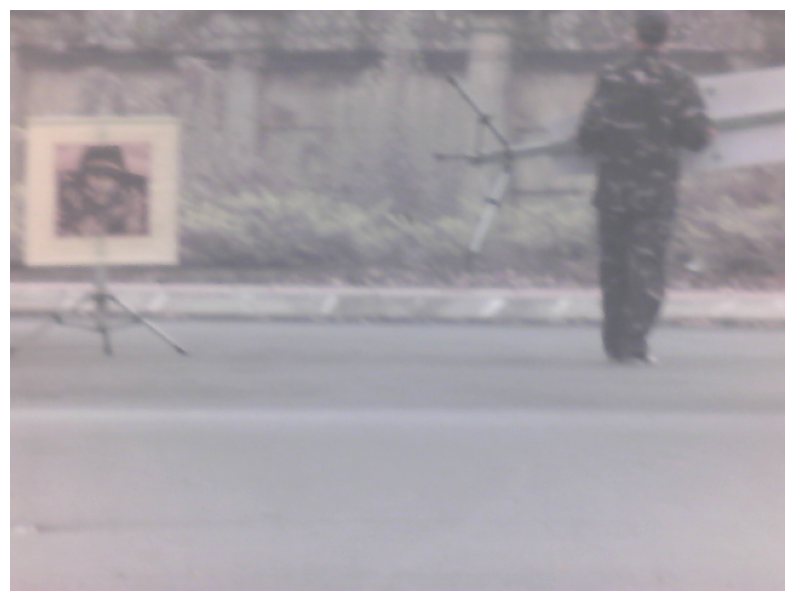

Results saved to images\bo du lieu bia so 4\bia4 (12)_detected.bmp


: 

In [ ]:
# 1. Perform detection
img_rgb, detections = detect_objects(image_path, model)

# 2. Visualize results
output_path = image_path.replace('.', '_detected.')
visualize_detections(img_rgb, detections, output_path)